In [185]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import geopandas as gpd

## Data resources

In [6]:
#matched_beer_data--ratings_with_text_rb
MBD_ratings_with_text_rb = pd.read_csv(".\\matched_beer_data\\ratings_with_text_rb.csv", sep = ",", header = 0)
#matched_beer_data--ratings_with_text_ba
MBD_ratings_with_text_ba = pd.read_csv(".\\matched_beer_data\\ratings_with_text_ba.csv", sep = ",", header = 0)

In [7]:
display(MBD_ratings_with_text_rb)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1429178400,ciaranc,151109,3,7,2,8,17,3.7,"Bottle, gift from Aaron. Black, big head, lots..."
1,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1427796000,Rowlymo,198957,4,7,4,8,15,3.8,500ml Bottle in Bittles bar Belfast. Chocolate...
2,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1421665200,Don2711,285162,4,8,5,7,17,4.1,Great one and made very local to me. Bottle bo...
3,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1380621600,genegenie,224156,5,8,3,5,19,4.0,"Deep roasted aroma, good dark brown/black colo..."
4,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1371549600,kiwianer,88501,4,7,4,7,14,3.6,"The head is medium, the body black. It smells ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020594,Korça 01 Lager Beer,153090,Birra Korça,8244,Pale Lager,4.1,1352977200,ogivlado,3019,2,3,2,3,6,1.6,"Bottled 500ml. -Courtesy of Marko, shared with..."
1020595,Korça 01 Lager Beer,153090,Birra Korça,8244,Pale Lager,4.1,1352804400,Marko,15284,3,3,2,3,5,1.6,"0.5l bottle courtesy of KreÅ¡o, who brought it..."
1020596,Korça 01 Lager Beer,153090,Birra Korça,8244,Pale Lager,4.1,1352631600,heavy,59683,2,2,2,3,5,1.4,"0.5 l bottle courtesy of Marko, thanks for sha..."
1020597,Korça 01 Lager Beer,153090,Birra Korça,8244,Pale Lager,4.1,1317117600,Quack-Duck,37612,3,4,2,4,10,2.3,"bottle, courtesy of KÃ¶lschtrinker - DankeschÃ..."


In [8]:
display(MBD_ratings_with_text_ba)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Legbiter,19827,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.8,1360753200,brewdude1982,brewdude1982.691169,4.25,4.50,3.25,3.75,3.75,3.91,This was a 12 oz bottle poured into a snifter....,True
1,Legbiter,19827,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.8,1357729200,AgentMunky,agentmunky.409755,4.00,3.75,3.50,3.50,3.75,3.64,Poured from a 12 ounce bottle into a pilsner g...,True
2,Legbiter,19827,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.8,1353150000,ferrari29,ferrari29.320392,3.00,3.50,2.50,2.50,2.50,2.77,Beer poured from bottle into a Nonic shaped pi...,True
3,Legbiter,19827,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.8,1342260000,OtherShoe2,othershoe2.233642,4.00,3.50,4.00,3.50,4.00,3.68,Pours a rich brownish red with some chill haze...,True
4,Legbiter,19827,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.8,1335607200,brentk56,brentk56.6284,4.50,3.00,3.50,2.50,2.50,2.84,Appearance,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289020,Lazy Saison,72174,Twisted Manzanita Ales,23640,Saison / Farmhouse Ale,7.0,1317290400,buzzardman,buzzardman.622276,3.00,2.00,2.00,1.00,2.00,1.66,I have to admit I have never had a saison styl...,True
289021,Night Before Christmas,77388,Twisted Manzanita Ales,23640,American Stout,7.4,1390820400,Mightykingmalard,mightykingmalard.771101,3.00,3.75,3.25,3.75,3.50,3.61,Appearance,True
289022,Night Before Christmas,77388,Twisted Manzanita Ales,23640,American Stout,7.4,1359370800,ALBuff,albuff.715358,4.00,4.25,3.50,3.75,4.00,3.91,If you'd ever wondered what it'd taste like to...,True
289023,Night Before Christmas,77388,Twisted Manzanita Ales,23640,American Stout,7.4,1357642800,HalfFull,halffull.196628,3.50,4.00,3.50,4.00,3.50,3.82,"Poured on tap into a shaker pint glass, showin...",True


**Data cleaning for MBD_ratings_with_text_ba**

In [9]:
# Check for missing values in each column 'MBD_ratings_with_text_ba'
MBD_ratings_with_text_ba_missing_values = MBD_ratings_with_text_ba.isnull().sum()
print("Missing values per column:")
print(MBD_ratings_with_text_ba_missing_values)

Missing values per column:
beer_name          1
beer_id            0
brewery_name       0
brewery_id         0
style              0
abv                0
date               0
user_name          0
user_id            0
appearance      5155
aroma           5155
palate          5155
taste           5155
overall         5155
rating             0
text               7
review             0
dtype: int64


In [10]:
#Drop the rows with empty 'text', check if any data has been droped
MBD_ratings_with_text_ba_no_duplicates = MBD_ratings_with_text_ba.copy().drop_duplicates()
MBD_ratings_with_text_ba_filtered = MBD_ratings_with_text_ba_no_duplicates.dropna(subset=['text'], how='all')
print(len(MBD_ratings_with_text_ba_filtered))

289018


In [11]:
#Check reviews distribution
MBD_ratings_with_text_ba_filtered_counts = MBD_ratings_with_text_ba_filtered['beer_id'].value_counts()
MBD_ratings_with_text_ba_filtered_counts = pd.DataFrame(data = MBD_ratings_with_text_ba_filtered_counts)
print(MBD_ratings_with_text_ba_filtered_counts.describe())

              count
count  28271.000000
mean      10.223126
std       53.640052
min        1.000000
25%        1.000000
50%        2.000000
75%        5.000000
max     2968.000000


**MBD_ratings_with_text_rb data cleaning**

In [12]:
# Check for missing values in each column
MBD_ratings_with_text_rb_missing_values = MBD_ratings_with_text_rb.isnull().sum()
print("Missing values per column:")
print(MBD_ratings_with_text_rb_missing_values)

Missing values per column:
beer_name       0
beer_id         0
brewery_name    0
brewery_id      0
style           0
abv             0
date            0
user_name       0
user_id         0
appearance      0
aroma           0
palate          0
taste           0
overall         0
rating          0
text            4
dtype: int64


In [13]:
#Drop the rows with empty 'text', check if any data has been droped
MBD_ratings_with_text_rb_no_duplicates = MBD_ratings_with_text_rb.copy().drop_duplicates()
MBD_ratings_with_text_rb_filtered = MBD_ratings_with_text_rb_no_duplicates.dropna(subset=['text'], how='all')
print(len(MBD_ratings_with_text_rb_filtered))

1020593


In [68]:
#Check reviews distribution
MBD_ratings_with_text_rb_filtered_counts = MBD_ratings_with_text_rb_filtered['beer_id'].value_counts()
MBD_ratings_with_text_rb_filtered_counts = pd.DataFrame(data = MBD_ratings_with_text_rb_filtered_counts)
print(MBD_ratings_with_text_rb_filtered_counts.describe())

              count
count  42228.000000
mean      24.168632
std       83.010641
min        1.000000
25%        2.000000
50%        5.000000
75%       18.000000
max     5270.000000


**Data processing**
- Drop the beer_id with reviews less than 2 for future sentiment analysis.
  Since for MBD_ratings_with_text_rb, 75% of the beer_id has more than 2 reviews, and for MBD_ratings_with_text_ba, 75% of the beer_id has more than 1 reviews and 50% of the beer_id has more than 2 reviews. As a trade-off, we decide to set threhold as 2. Moreover, this way we'll obtain more representative dataset of reviews for moods detection.

In [115]:
MBD_ratings_with_text_ba_filtered_counts = MBD_ratings_with_text_ba_filtered['beer_id'].value_counts()
beers_to_keep = MBD_ratings_with_text_ba_filtered_counts[MBD_ratings_with_text_ba_filtered_counts >= 2].index
mask = MBD_ratings_with_text_ba_filtered['beer_id'].isin(beers_to_keep)
filtered_data_ba = MBD_ratings_with_text_ba_filtered[mask]

In [116]:
filtered_data_ba_counts = filtered_data_ba['beer_id'].value_counts()
filtered_data_ba_counts = pd.DataFrame(data = filtered_data_ba_counts)
print(filtered_data_ba_counts.describe())

              count
count  16155.000000
mean      17.140328
std       70.168602
min        2.000000
25%        2.000000
50%        4.000000
75%       10.000000
max     2968.000000


In [117]:
MBD_ratings_with_text_rb_filtered_counts = MBD_ratings_with_text_rb_filtered['beer_id'].value_counts()
beers_to_keep = MBD_ratings_with_text_rb_filtered_counts[MBD_ratings_with_text_rb_filtered_counts >= 2].index
mask = MBD_ratings_with_text_rb_filtered['beer_id'].isin(beers_to_keep)
filtered_data_rb = MBD_ratings_with_text_rb_filtered[mask]

In [118]:
filtered_data_rb_counts = filtered_data_rb['beer_id'].value_counts()
filtered_data_rb_counts = pd.DataFrame(data = filtered_data_rb_counts)
print(filtered_data_rb_counts.describe())

              count
count  34824.000000
mean      29.094561
std       90.650275
min        2.000000
25%        3.000000
50%        8.000000
75%       23.000000
max     5270.000000


### Data visualization

**MBD_ratings_with_text_ba**
- Beer Review

D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


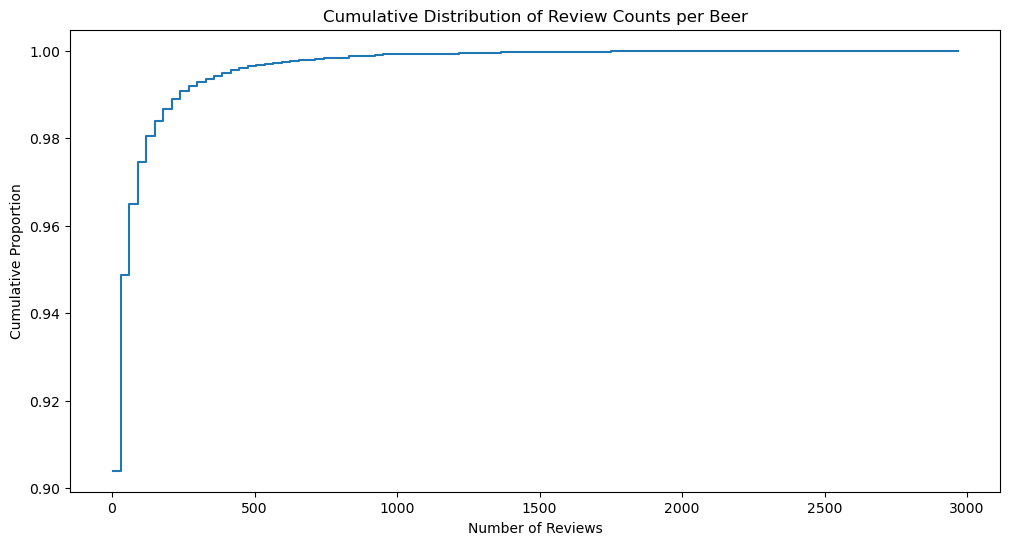

In [96]:
# Cumulative Distribution Plot
plt.figure(figsize=(12, 6))
sns.histplot(review_counts_ba, bins=100, cumulative=True, stat="density", element="step", fill=False)
plt.title("Cumulative Distribution of Review Counts per Beer")
plt.xlabel("Number of Reviews")
plt.ylabel("Cumulative Proportion")
plt.show()

- Most Popular Beer Styles

D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


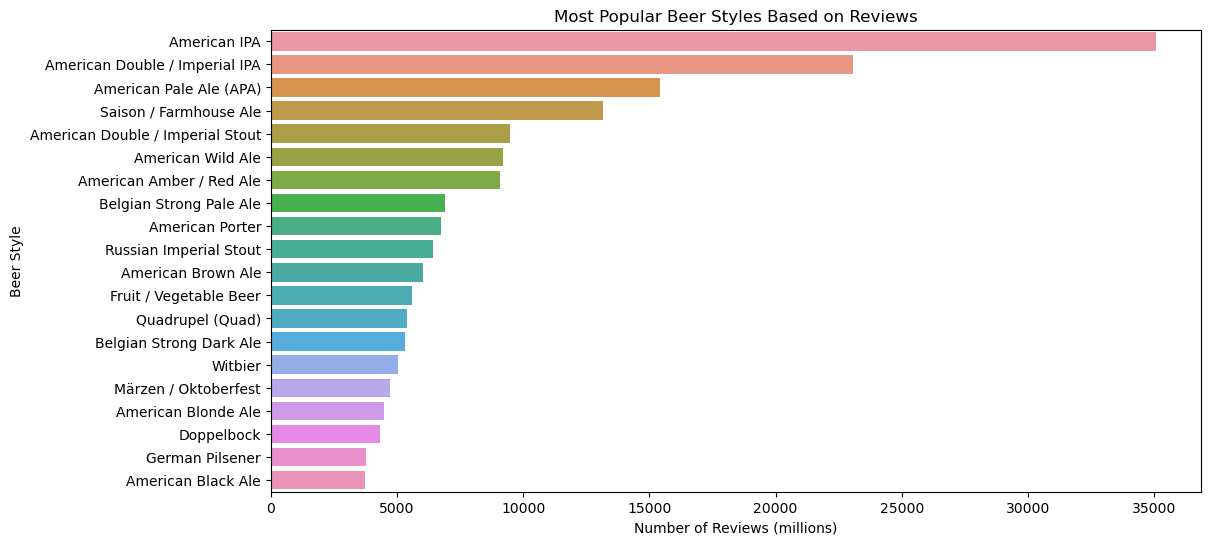

In [97]:
# Aggregate review counts by beer style
style_counts_ba = MBD_ratings_with_text_ba_filtered['style'].value_counts()

# Select the top N styles for visualization
# Adjust the number (e.g., 20) to display more or fewer styles
top_styles_ba = style_counts_ba.head(20)

# Create a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=top_styles_ba.values, y=top_styles_ba.index)
plt.title("Most Popular Beer Styles Based on Reviews")
plt.xlabel("Number of Reviews (millions)")
plt.ylabel("Beer Style")
plt.show()

In [182]:
texts = filtered_data_ba['text']
additional_stopwords = {'beer', 'beers'}
stopwords = set(STOPWORDS).union(additional_stopwords)
print(stopwords)

{'below', 'k', 'more', 'been', 'by', 'what', 'were', 'an', 'would', 'him', 'not', 'those', 'should', 'when', "we've", 'ourselves', 'do', 'am', "hasn't", 'doing', 'being', 'each', 'her', 'our', 'such', 'they', "weren't", 'had', 'as', 'them', "when's", 'after', 'to', "i'll", 'me', 'myself', 'most', 'my', "there's", 'www', 'having', 'was', 'while', 'whom', 'does', "they'll", "hadn't", 'of', 'hence', 'you', "isn't", 'under', 'ought', "shan't", "wouldn't", 'above', 'where', "that's", "shouldn't", 'further', 'theirs', 'like', 'with', 'get', 'beer', 'any', 'could', "they'd", 'if', 'itself', 'it', 'against', "aren't", 'your', 'did', 'are', 'this', 'very', 'in', 'into', "you'd", 'these', 'but', 'only', "we'll", 'http', 'through', 'r', "i'd", 'himself', 'both', 'at', 'its', 'then', 'else', 'he', 'beers', 'off', "she'll", "what's", 'up', 'other', "you've", 'however', "here's", "we're", 'i', 'about', "wasn't", 'few', 'too', 'so', 'their', "she's", 'can', "don't", "can't", 'we', 'for', 'no', 'on', 

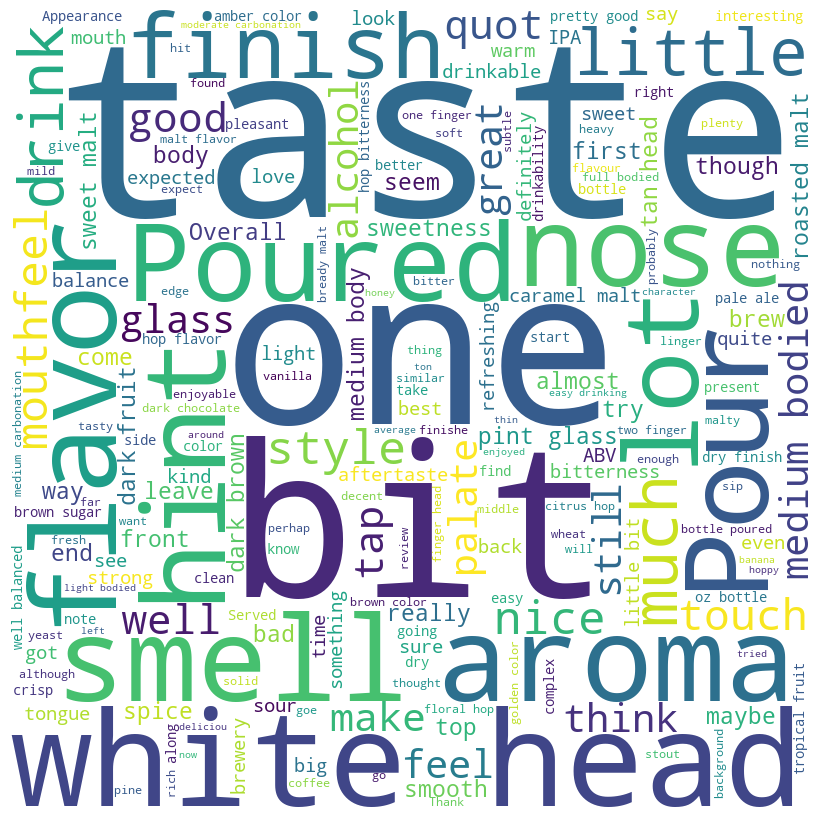

CPU times: total: 40 s
Wall time: 42.4 s


In [183]:
%%time

beer_can_image = 'C:\\Users\\ROG\\Desktop\\VK750.jpg'
mask = np.array(Image.open(beer_can_image))


wordcloud = WordCloud(
    width = 800, height = 800, 
    background_color ='white', 
    stopwords = stopwords, 
    min_font_size = 10,
)

wordcloud.generate(' '.join(texts))

# 绘制词云
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

**MBD_ratings_with_text_rb**
- Beer Review

D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


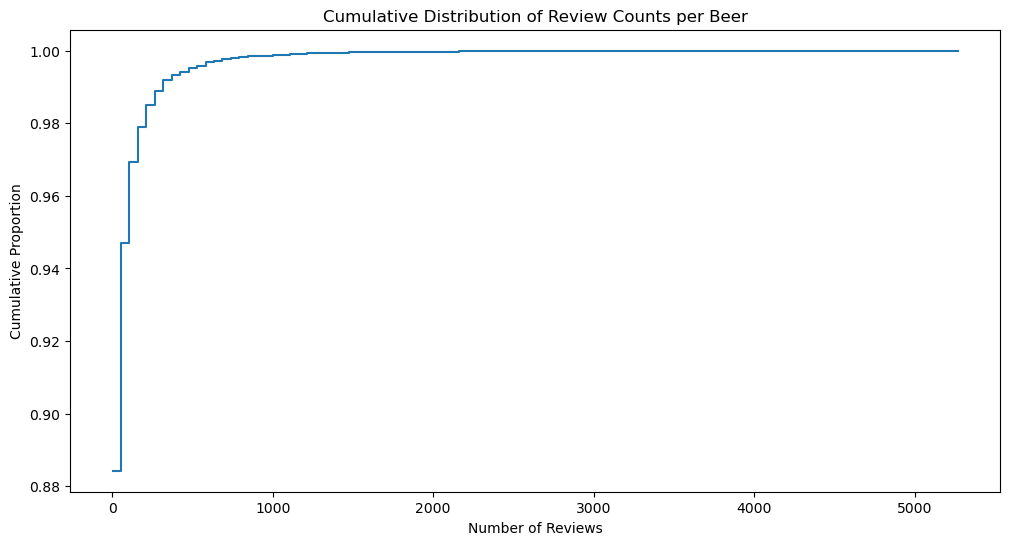

In [98]:
# Cumulative Distribution Plot
plt.figure(figsize=(12, 6))
sns.histplot(review_counts_rb, bins=100, cumulative=True, stat="density", element="step", fill=False)
plt.title("Cumulative Distribution of Review Counts per Beer")
plt.xlabel("Number of Reviews")
plt.ylabel("Cumulative Proportion")
plt.show()

- Most Popular Beer Styles

D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


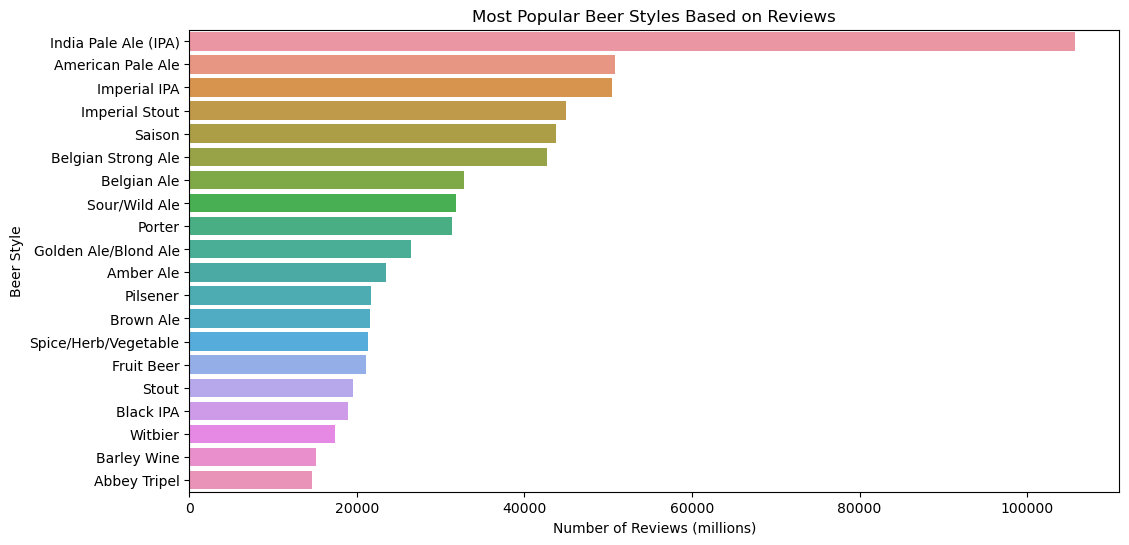

In [99]:
# Aggregate review counts by beer style
style_counts_rb = MBD_ratings_with_text_rb_filtered['style'].value_counts()

# Select the top N styles for visualization
# Adjust the number (e.g., 20) to display more or fewer styles
top_styles_rb = style_counts_rb.head(20)

# Create a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=top_styles_rb.values, y=top_styles_rb.index)
plt.title("Most Popular Beer Styles Based on Reviews")
plt.xlabel("Number of Reviews (millions)")
plt.ylabel("Beer Style")
plt.show()

In [130]:
texts = filtered_data_rb['text']
additional_stopwords = {'beer', 'beers'}
stopwords = set(STOPWORDS).union(additional_stopwords)
print(stopwords)

{'below', 'k', 'more', 'been', 'by', 'what', 'were', 'an', 'would', 'him', 'not', 'those', 'should', 'when', "we've", 'ourselves', 'do', 'am', "hasn't", 'doing', 'being', 'each', 'her', 'our', 'such', 'they', "weren't", 'had', 'as', 'them', "when's", 'after', 'to', "i'll", 'me', 'myself', 'most', 'my', "there's", 'www', 'having', 'was', 'while', 'whom', 'does', "they'll", "hadn't", 'of', 'hence', 'you', "isn't", 'under', 'ought', "shan't", "wouldn't", 'above', 'where', "that's", "shouldn't", 'further', 'theirs', 'like', 'with', 'get', 'beer', 'any', 'could', "they'd", 'if', 'itself', 'it', 'against', "aren't", 'your', 'did', 'are', 'this', 'very', 'in', 'into', "you'd", 'these', 'but', 'only', "we'll", 'http', 'through', 'r', "i'd", 'himself', 'both', 'at', 'its', 'then', 'else', 'he', 'beers', 'off', "she'll", "what's", 'up', 'other', "you've", 'however', "here's", "we're", 'i', 'about', "wasn't", 'few', 'too', 'so', 'their', "she's", 'can', "don't", "can't", 'we', 'for', 'no', 'on', 

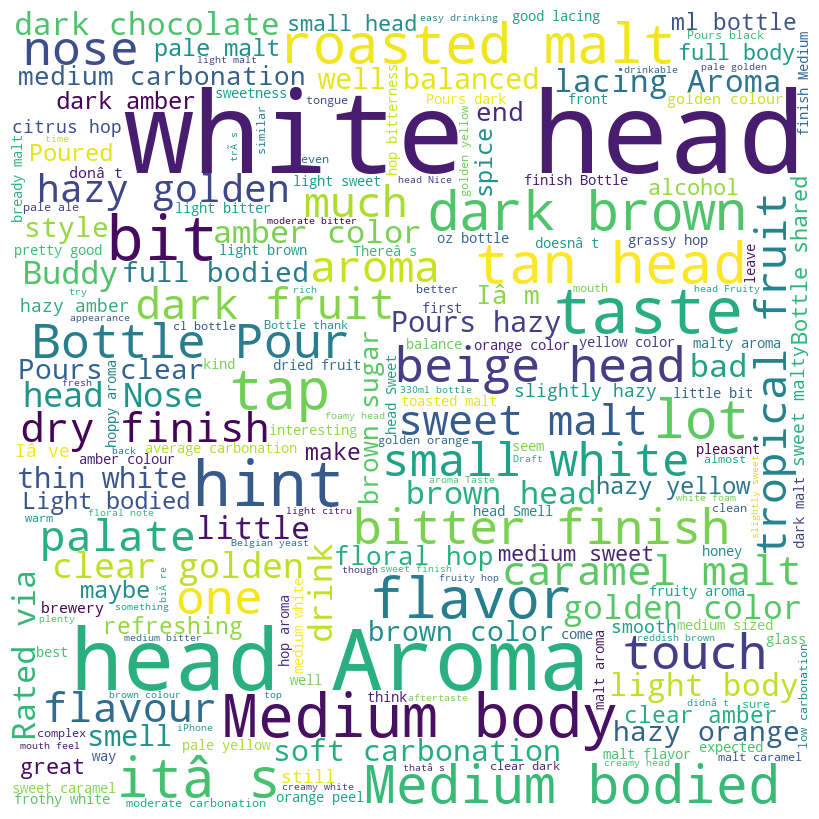

CPU times: total: 1min 25s
Wall time: 1min 31s


In [138]:
%%time

beer_can_image = 'C:\\Users\\ROG\\Desktop\\VK750.jpg'
mask = np.array(Image.open(beer_can_image))


wordcloud = WordCloud(
    width = 800, height = 800, 
    background_color ='white', 
    stopwords = stopwords, 
    min_font_size = 10,
)

wordcloud.generate(' '.join(texts))

# 绘制词云
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

**Compared two datasets**
- Beer Reviews

D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


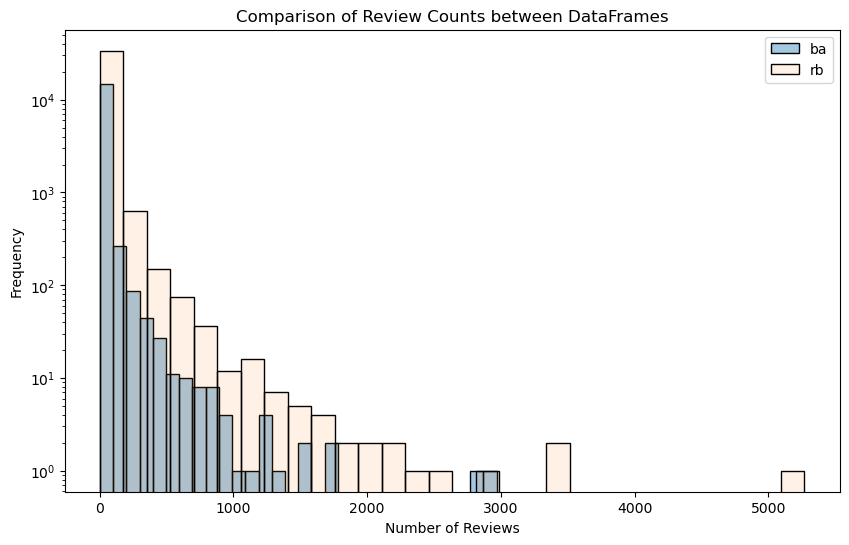

In [103]:
review_counts_ba = filtered_data_ba['beer_name'].value_counts()
review_counts_rb = filtered_data_rb['beer_name'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(review_counts_ba, bins=30, label='ba',log_scale=(False, True), alpha=0.4)
sns.histplot(review_counts_rb, bins=30, label='rb',log_scale=(False, True), alpha=0.1)

plt.title('Comparison of Review Counts between DataFrames')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.legend()
plt.show()

- Beer Ratings

C:\Users\ROG\AppData\Local\Temp\ipykernel_8592\176453736.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_ba['source'] = 'BeerAdvocate'
C:\Users\ROG\AppData\Local\Temp\ipykernel_8592\176453736.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_rb['source'] = 'RateBeer'
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.ty

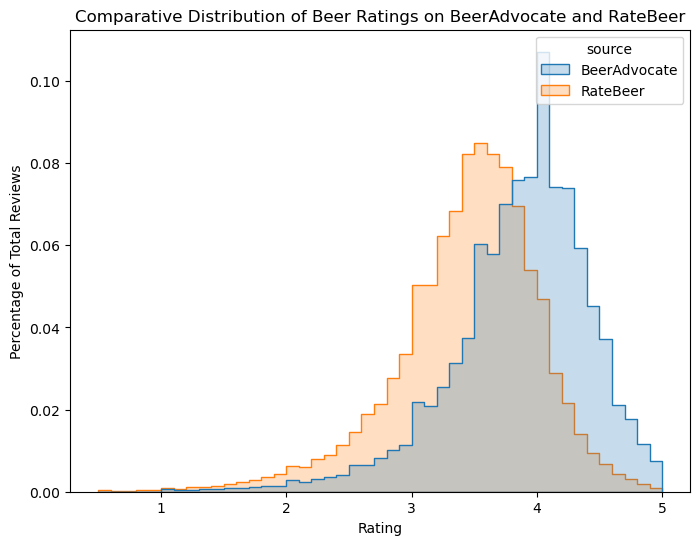

In [155]:
filtered_data_ba['source'] = 'BeerAdvocate'
filtered_data_rb['source'] = 'RateBeer'

all_reviews = pd.concat([filtered_data_ba, filtered_data_rb], ignore_index=True)
plt.figure(figsize=(8, 6))
sns.histplot(data=all_reviews[['rating', 'source']], 
             x='rating', hue='source', 
             element='step', stat='probability', 
             common_norm=False, binwidth=0.1)
plt.title("Comparative Distribution of Beer Ratings on BeerAdvocate and RateBeer")
plt.xlabel("Rating")
plt.ylabel("Percentage of Total Reviews")
plt.show()

- Beer Ratings(standardization)

In [156]:
# Rating standerlization for filtered_data_ba.
mean_rating = filtered_data_ba['rating'].mean()
std_rating = filtered_data_ba['rating'].std()

# Standardize the 'ratings' column
filtered_data_ba['standardized_ratings'] = (filtered_data_ba['rating'] - mean_rating) / std_rating

C:\Users\ROG\AppData\Local\Temp\ipykernel_8592\4114009979.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_ba['standardized_ratings'] = (filtered_data_ba['rating'] - mean_rating) / std_rating


In [157]:
# Rating standerlization for filtered_data_rb.
mean_rating = filtered_data_rb['rating'].mean()
std_rating = filtered_data_rb['rating'].std()

# Standardize the 'ratings' column
filtered_data_rb['standardized_ratings'] = (filtered_data_rb['rating'] - mean_rating) / std_rating

C:\Users\ROG\AppData\Local\Temp\ipykernel_8592\1165464610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_rb['standardized_ratings'] = (filtered_data_rb['rating'] - mean_rating) / std_rating


D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-pa

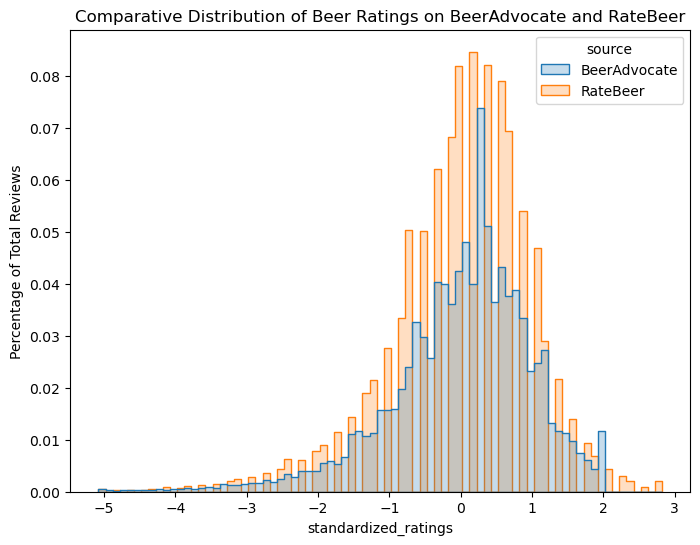

In [160]:
all_reviews_std = pd.concat([filtered_data_ba, filtered_data_rb], ignore_index=True)
plt.figure(figsize=(8, 6))
sns.histplot(data=all_reviews_std[['standardized_ratings', 'source']], 
             x='standardized_ratings', hue='source', 
             element='step', stat='probability', 
             common_norm=False, binwidth=0.1)
plt.title("Comparative Distribution of Beer Ratings on BeerAdvocate and RateBeer")
plt.xlabel("standardized_ratings")
plt.ylabel("Percentage of Total Reviews")
plt.show()

- Beer appearance

D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-pa

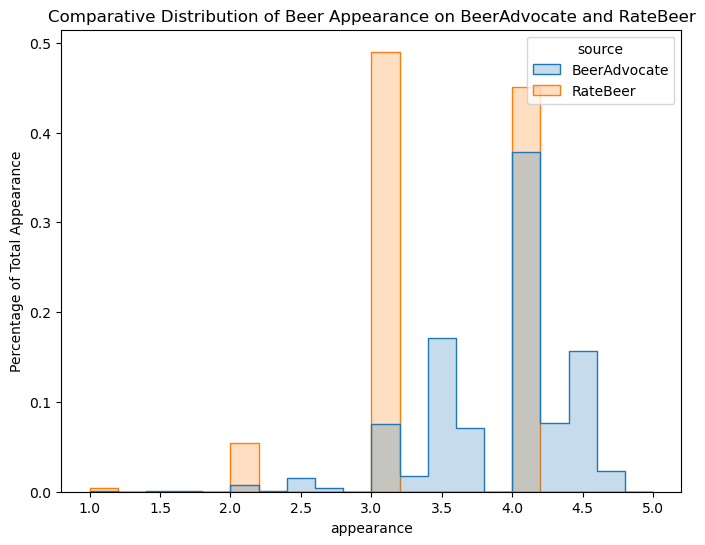

In [168]:
plt.figure(figsize=(8, 6))
sns.histplot(data=all_reviews[['appearance', 'source']], 
             x='appearance', hue='source', 
             element='step', stat='probability', 
             common_norm=False, binwidth=0.2)
plt.title("Comparative Distribution of Beer Appearance on BeerAdvocate and RateBeer")
plt.xlabel("appearance")
plt.ylabel("Percentage of Total Appearance")
plt.show()

- Beer aroma

D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-pa

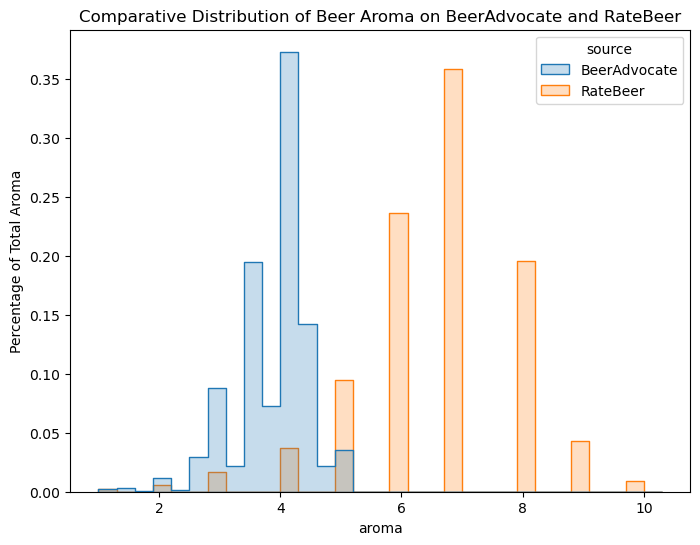

In [171]:
plt.figure(figsize=(8, 6))
sns.histplot(data=all_reviews[['aroma', 'source']], 
             x='aroma', hue='source', 
             element='step', stat='probability', 
             common_norm=False, binwidth=0.3)
plt.title("Comparative Distribution of Beer Aroma on BeerAdvocate and RateBeer")
plt.xlabel("aroma")
plt.ylabel("Percentage of Total Aroma")
plt.show()

- Beer palate

D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-pa

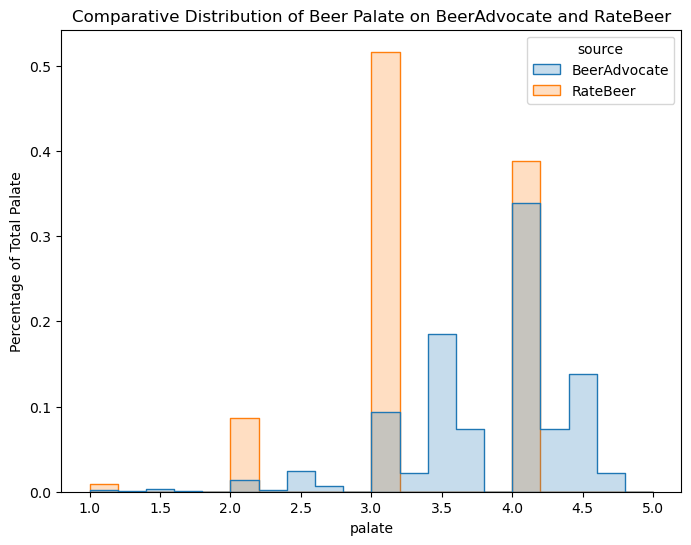

In [173]:
plt.figure(figsize=(8, 6))
sns.histplot(data=all_reviews[['palate', 'source']], 
             x='palate', hue='source', 
             element='step', stat='probability', 
             common_norm=False, binwidth=0.2)
plt.title("Comparative Distribution of Beer Palate on BeerAdvocate and RateBeer")
plt.xlabel("palate")
plt.ylabel("Percentage of Total Palate")
plt.show()

- Beer taste

D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-pa

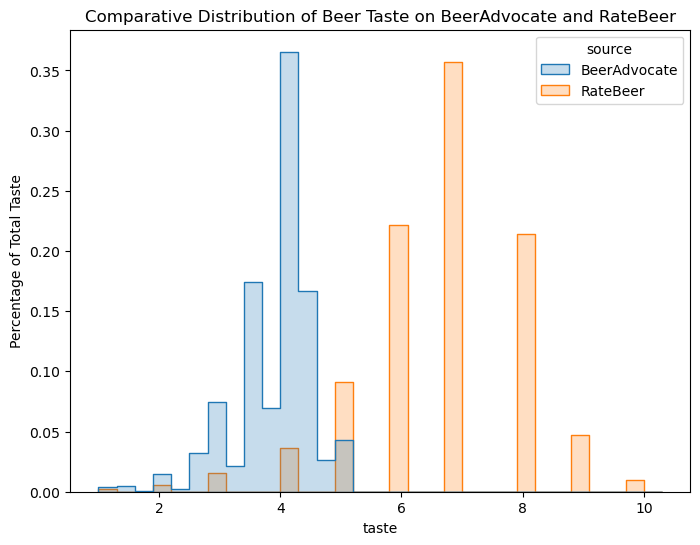

In [181]:
plt.figure(figsize=(8, 6))
sns.histplot(data=all_reviews[['taste', 'source']], 
             x='taste', hue='source', 
             element='step', stat='probability', 
             common_norm=False, binwidth=0.3)
plt.title("Comparative Distribution of Beer Taste on BeerAdvocate and RateBeer")
plt.xlabel("taste")
plt.ylabel("Percentage of Total Taste")
plt.show()

- Beer overall

D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-pa

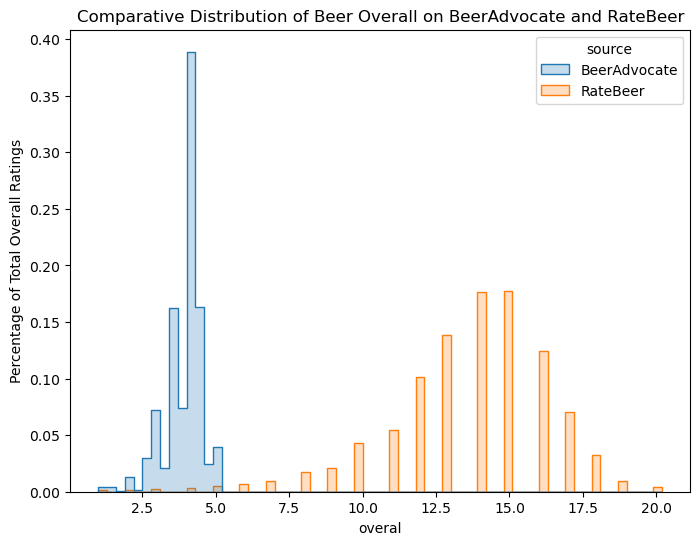

In [180]:
plt.figure(figsize=(8, 6))
sns.histplot(data=all_reviews[['overall', 'source']], 
             x='overall', hue='source', 
             element='step', stat='probability', 
             common_norm=False, binwidth=0.3)
plt.title("Comparative Distribution of Beer Overall on BeerAdvocate and RateBeer")
plt.xlabel("overal")
plt.ylabel("Percentage of Total Overall Ratings")
plt.show()

In [184]:
!pip install geopandas

  Obtaining dependency information for geopandas from https://files.pythonhosted.org/packages/3e/cf/ede993ed7070c5487e6db550aad490178c06eaa48ad26ff5e5263f995fba/geopandas-0.14.1-py3-none-any.whl.metadata
  Obtaining dependency information for fiona>=1.8.21 from https://files.pythonhosted.org/packages/7f/27/b24c1610c7ae5716709321f04d38d7b8b71ed531f80df4f697b9ad99cfc3/fiona-1.9.5-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/51.1 kB ? eta -:--:--
     ------------------------------ ------- 41.0/51.1 kB 991.0 kB/s eta 0:00:01
     -------------------------------------- 51.1/51.1 kB 869.6 kB/s eta 0:00:00
  Obtaining dependency information for pyproj>=3.3.0 from https://files.pythonhosted.org/packages/79/95/eb68113c5b5737c342bde1bab92705dabe69c16299c5a122616e50f1fbd6/pyproj-3.6.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for shapely>=1.8.0 from https://files.pythonhosted.org/packages/9e/39/029c441d8af32ab423b229c4525ce5ce67

In [188]:

print(df.head())

             ba                       ba.1         ba.2         ba.3  \
0        joined                   location  nbr_ratings  nbr_reviews   
1  1220868000.0                    Germany            6            6   
2  1348394400.0    United States, Virginia            1            1   
3  1207303200.0  United States, Washington            3            3   
4  1322737200.0                    Estonia           11            0   

                 ba.4         ba.5             ba.6            rb  \
0             user_id    user_name  user_name_lower        joined   
1     erzengel.248045     Erzengel         erzengel  1224324000.0   
2     gendv138.695700     GenDV138         gendv138  1385722800.0   
3   nimbleprop.208928   nimbleprop       nimbleprop  1150797600.0   
4  visionthing.639993  visionthing      visionthing  1242986400.0   

                        rb.1         rb.2     rb.3         rb.4  \
0                   location  nbr_ratings  user_id    user_name   
1                 

C:\Users\ROG\AppData\Local\Temp\ipykernel_8592\507964288.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


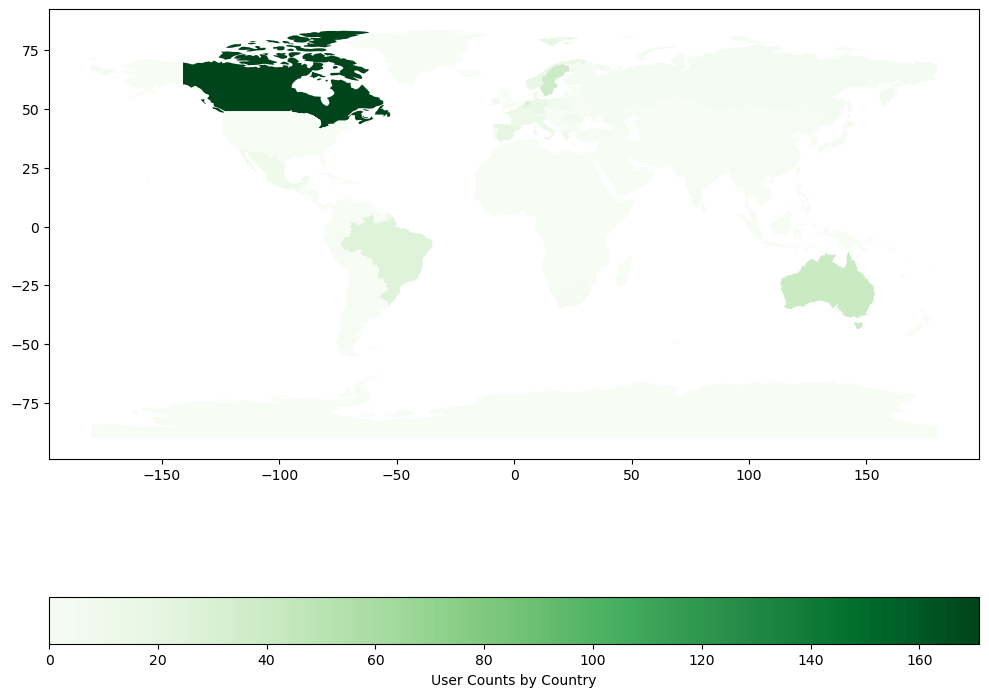

In [210]:
file_path = 'C:\\Users\\ROG\\Desktop\\beer_review\\matched_beer_data\\users.csv'  # 替换为您的文件路径
df = pd.read_csv(file_path)

# 假设用户地区信息在名为 'user_location' 的列
user_counts = df['ba.1'].value_counts().reset_index()
user_counts.columns = ['country', 'count']

# 加载世界地图数据
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# 合并世界地图数据和用户数量数据
# 注意：这里可能需要根据您的数据集中国家名称的具体情况做一些调整
world = world.merge(user_counts, how='left', left_on='name', right_on='country')

# 用户数量为NaN的地区设置为0
world['count'] = world['count'].fillna(0)

# 绘制地图
world.plot(column='count', cmap='Greens', figsize=(12, 12), legend=True,
           legend_kwds={'label': "User Counts by Country",
                        'orientation': "horizontal"})
plt.show()